# Download Data

In [0]:
from google.colab import files

In [0]:
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"riadhbal","key":"d19913c628c1a186d6ce35639bfa507c"}'}

In [0]:
!rm /root/.kaggle
!mkdir /root/.kaggle
!mv kaggle.json /root/.kaggle

rm: cannot remove '/root/.kaggle': No such file or directory


In [0]:
!kaggle competitions download -c ashrae-energy-prediction

 98% 117M/120M [00:00<00:00, 259MB/s] 
100% 120M/120M [00:00<00:00, 302MB/s]
  0% 0.00/44.5k [00:00<?, ?B/s]
100% 44.5k/44.5k [00:00<00:00, 44.8MB/s]
  0% 0.00/2.53M [00:00<?, ?B/s]
100% 2.53M/2.53M [00:00<00:00, 171MB/s]
 94% 156M/167M [00:00<00:00, 221MB/s]
100% 167M/167M [00:00<00:00, 228MB/s]
  0% 0.00/1.27M [00:00<?, ?B/s]
100% 1.27M/1.27M [00:00<00:00, 169MB/s]
 88% 78.0M/88.4M [00:00<00:00, 250MB/s]
100% 88.4M/88.4M [00:00<00:00, 253MB/s]


In [0]:
!unzip sample_submission.csv.zip
!unzip test.csv.zip
!unzip train.csv.zip
!unzip weather_train.csv.zip
!unzip weather_test.csv.zip

Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   
Archive:  test.csv.zip
  inflating: test.csv                
Archive:  train.csv.zip
  inflating: train.csv               
Archive:  weather_train.csv.zip
  inflating: weather_train.csv       
Archive:  weather_test.csv.zip
  inflating: weather_test.csv        


In [0]:
!rm sample_submission.csv.zip
!rm test.csv.zip
!rm train.csv.zip
!rm weather_train.csv.zip
!rm weather_test.csv.zip

In [0]:
!mkdir -p kaggle/input
!mv sample_submission.csv /content/kaggle/input
!mv test.csv /content/kaggle/input
!mv train.csv /content/kaggle/input
!mv weather_train.csv /content/kaggle/input
!mv weather_test.csv /content/kaggle/input
!mv building_metadata.csv /content/kaggle/input

In [0]:
! pip install plotly.express

# Load libraries

In [0]:
import numpy as np 
import pandas as pd
import math 
import random
import os

from keras.models import Model, load_model, Sequential
from keras.layers import Input, Dropout, Dense, Embedding, SpatialDropout1D, concatenate, BatchNormalization, Flatten
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import text, sequence
from keras.callbacks import Callback
from keras import backend as K
from keras.models import Model
from keras.losses import mean_squared_error as mse_loss
from keras import optimizers
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split


/content
kaggle/input/weather_train.csv
kaggle/input/sample_submission.csv
kaggle/input/building_metadata.csv
kaggle/input/test.csv
kaggle/input/train.csv
kaggle/input/weather_test.csv


# Loading data

In [0]:
building_df = pd.read_csv("kaggle/input/building_metadata.csv")
weather_train = pd.read_csv("kaggle/input/weather_train.csv")
train_df= pd.read_csv("kaggle/input/train.csv")

# Preprocessing data

In [0]:
#Joindre les 3 tableaux en un seul par 3 clés
train=train_df.copy()
train = train.merge(building_df, left_on = "building_id", right_on = "building_id", how = "left")
train = train.merge(weather_train, left_on = ["site_id", "timestamp"], right_on = ["site_id", "timestamp"],how = "left")
train.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,1,0,2016-01-01 00:00:00,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
2,2,0,2016-01-01 00:00:00,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
3,3,0,2016-01-01 00:00:00,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
4,4,0,2016-01-01 00:00:00,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0


## Removing Outliers
meter - The meter id code. Read as {0: electricity, 1: chilledwater, 2: steam, hotwater: 3}


D'après les Boxplot ci-dessous on remarque qu'il ya des outliers dans le dataset, qui sont plus remarquables pour le metric 2 qui est le steam

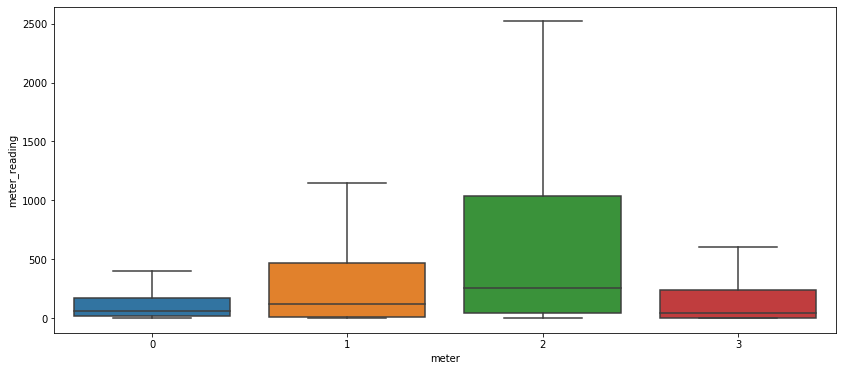

In [0]:
#Boxplot avant d'éliminer les outliers
fig, axes = plt.subplots(1, 1, figsize=(14, 6))
sns.boxplot(x='meter', y='meter_reading', data=train, showfliers=False)

In [0]:
daily_train =train_df.copy() 
daily_train['meter'] = pd.Categorical(daily_train['meter']).rename_categories({0: 'electricity', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'})
daily_train['timestamp'] = pd.to_datetime(daily_train.timestamp)
daily_train['date'] = daily_train['timestamp'].dt.date
daily_train = daily_train.groupby(['date', 'building_id', 'meter']).sum()
daily_train_agg = daily_train.groupby(['date', 'meter']).agg(['sum', 'mean', 'idxmax', 'max'])
daily_train_agg = daily_train_agg.reset_index()
level_0 = daily_train_agg.columns.droplevel(0)
level_1 = daily_train_agg.columns.droplevel(1)
level_0 = ['' if x == '' else '-' + x for x in level_0]
daily_train_agg.columns = level_1 + level_0
daily_train_agg.rename_axis(None, axis=1)
daily_train_agg['building_id_max'] = [x[1] for x in daily_train_agg['meter_reading-idxmax']]
daily_train_agg.head()

,date,meter,meter_reading-sum,meter_reading-mean,meter_reading-idxmax,meter_reading-max,building_id_max
0,2016-01-01,electricity,4.219647e+06,3037.903035,"(2016-01-01, 803, electricity)",116037.18,803
1,2016-01-01,chilledwater,1.412169e+06,3090.084935,"(2016-01-01, 1289, chilledwater)",104211.65,1289
2,2016-01-01,steam,6.873201e+07,218891.736502,"(2016-01-01, 1099, steam)",50950800.00,1099
3,2016-01-01,hotwater,1.609989e+06,11180.481533,"(2016-01-01, 1331, hotwater)",219824.53,1331
4,2016-01-02,electricity,4.288951e+06,3085.576378,"(2016-01-02, 803, electricity)",115776.75,803


In [0]:
fig_total = px.line(daily_train_agg, x='date', y='meter_reading-sum', color='meter', render_mode='svg')
fig_total.update_layout(title='total consommation (KWH)')
fig_total.show()


**Il est bien clair d'après la figure ci-dessus qu'il y a des valeurs aberantes causées essentiellement par le metric steam car la consommation total d'énérgie montre des grandeurs très variées entre le steam et les différents types de metrics.**

In [0]:
fig_maximum = px.line(daily_train_agg, x='date', y='meter_reading-max', color='meter', render_mode='svg')
fig_maximum.update_layout(title='Maximum consommation (kWh) ')
fig_maximum.show()

**En analysant la consommation maximale jounalière on remarque qu'un seul Building par jour et par type de metric steam est le responsable des pics abérants.**

In [0]:
print('Nombre de jour qu\'un building a une consommation maximale de steam  :\n')
print(daily_train_agg[daily_train_agg['meter'] == 'steam']['building_id_max'].value_counts())
daily_train_steam = daily_train_agg[daily_train_agg['meter']=='steam'].copy()
daily_train_steam['building_id_max'] = pd.Categorical(daily_train_steam['building_id_max'])
fig_daily_steam = px.scatter(daily_train_steam,
                             x='date',
                             y='meter_reading-max',
                             color='building_id_max',
                             render_mode='svg')
fig_daily_steam.update_layout(title='Maximum consommation (KWH) pour le steam metric')
fig_daily_steam.show()

Nombre de jour qu'un building a une consommation maximale de steam  :

1099    158
1197    101
1168    100
1148      7
Name: building_id_max, dtype: int64


**D'après le figure ci-dessus On remarque  que le Building 1099 possède une consommation  maximale avec des valeurs  très élevées par rapport aux autres valeurs maximales, alors on ce builduing répresente des valeurs abérantes va être éliminée**

In [0]:
daily_train_AR =train_df.copy() 
daily_train_AR.loc[daily_train_AR['building_id']==1099,"outlier"]=True
daily_train_AR = daily_train_AR [daily_train_AR ["outlier"]!=True]
daily_train_AR['meter'] = pd.Categorical(daily_train_AR['meter']).rename_categories({0: 'electricity', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'})
daily_train_AR['timestamp'] = pd.to_datetime(daily_train_AR.timestamp)
daily_train_AR['date'] = daily_train_AR['timestamp'].dt.date
daily_train_AR = daily_train_AR.groupby(['date', 'building_id', 'meter']).sum()
daily_train_AR_agg = daily_train_AR.groupby(['date', 'meter']).agg(['sum', 'mean', 'idxmax', 'max'])
daily_train_AR_agg = daily_train_AR_agg.reset_index()
level_0 = daily_train_AR_agg.columns.droplevel(0)
level_1 = daily_train_AR_agg.columns.droplevel(1)
level_0 = ['' if x == '' else '-' + x for x in level_0]
daily_train_AR_agg.columns = level_1 + level_0
daily_train_AR_agg.rename_axis(None, axis=1)
daily_train_AR_agg['building_id_max'] = [x[1] for x in daily_train_agg['meter_reading-idxmax']]
fig_total = px.line(daily_train_AR_agg, x='date', y='meter_reading-sum', color='meter', render_mode='svg')
fig_total.update_layout(title='total consommation (KWH) après élimination du building 1099')
fig_total.show()

In [0]:
del daily_train_AR, daily_train_AR_agg, daily_train, daily_train_agg 

In [0]:
#Eliminer les données relatives au Building 1099 dans le train dataset
train.loc[train['building_id']==1099,"outlier"]=True
train = train[train["outlier"]!=True]


## Fill out missing data

In [0]:
# (%) Missing data Before fill out
100 * train.isnull().sum() / len(train)

building_id             0.000000
meter                   0.000000
timestamp               0.000000
meter_reading           0.000000
site_id                 0.000000
primary_use             0.000000
square_feet             0.000000
year_built             59.955237
floor_count            82.637685
air_temperature         0.478520
cloud_coverage         43.650529
dew_temperature         0.495759
precip_depth_1_hr      18.560738
sea_level_pressure      6.096616
wind_direction          7.171867
wind_speed              0.711299
outlier               100.000000
dtype: float64

In [0]:
# consommation d'électricité avant '2016-05-21 00:00:00' est nulle pour tout les building vont être eliminés 
train.loc[(train['meter']==0) & (train['site_id']==0) & (train['timestamp']<'2016-05-21 00:00:00'), 'drop'] = True
train = train[train['drop']!=True]

# Création des nouvelles features 
    # 1) Hour et Weekday à partir de la variable timestamp 
train["timestamp"] = pd.to_datetime(train["timestamp"])
train["hour"] = train["timestamp"].dt.hour
train["weekday"] = train["timestamp"].dt.weekday

    # 2) On utilise le beaufort scale pour convertir le wind speed en une variable discrète 
beaufort = [(0, 0, 0.3), (1, 0.3, 1.6), (2, 1.6, 3.4), (3, 3.4, 5.5), (4, 5.5, 8), (5, 8, 10.8), (6, 10.8, 13.9), 
          (7, 13.9, 17.2), (8, 17.2, 20.8), (9, 20.8, 24.5), (10, 24.5, 28.5), (11, 28.5, 33), (12, 33, 200)]

for item in beaufort:
    train.loc[(train['wind_speed']>=item[1]) & (train['wind_speed']<item[2]), 'beaufort_scale'] = item[0]


#Remplir les valeurs manquantes des variables numériques par la moyenne horaire par type de metric 
def average_imputation(df, column_name):
    imputation = df.groupby(['timestamp'])[column_name].mean()  
    df.loc[df[column_name].isnull(), column_name] = df[df[column_name].isnull()][[column_name]].apply(lambda x: imputation[df['timestamp'][x.index]].values)
    del imputation
    return df
train = average_imputation(train, 'wind_speed')
train = average_imputation(train,'sea_level_pressure')
train = average_imputation(train,'dew_temperature')
train = average_imputation(train, 'air_temperature')
train = average_imputation(train,'precip_depth_1_hr')
train = average_imputation(train, 'cloud_coverage')
train['cloud_coverage']=round(train['cloud_coverage'])
train['wind_direction'] = train['wind_direction'].apply(lambda x: random.random() * 360.0 if (math.isnan(x)) else x)

del train["timestamp"]

In [0]:
# (%) Missing data After fill out
100 * train.isnull().sum() / len(train)

building_id             0.000000
meter                   0.000000
meter_reading           0.000000
site_id                 0.000000
primary_use             0.000000
square_feet             0.000000
year_built             61.008035
floor_count            82.332808
air_temperature         0.000000
cloud_coverage          0.219295
dew_temperature         0.000000
precip_depth_1_hr       0.011063
sea_level_pressure      0.000000
wind_direction          0.000000
wind_speed              0.000000
outlier               100.000000
drop                  100.000000
hour                    0.000000
weekday                 0.000000
beaufort_scale          0.723789
dtype: float64

In [0]:
# Label encoding pour le primary use
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train["primary_use"] = le.fit_transform(train["primary_use"])

# On définit les variables numériques,et catégoriques et à éliminer 
categoricals = ["site_id", "building_id", "primary_use", "hour", "weekday",  "meter"]

#les varibles "year_built" et "floor_count" vont être éliminées à cause du nombre élevée des missing values 
drop_cols = ["year_built","floor_count", "drop"]

numericals= ["square_feet", "air_temperature", "cloud_coverage",
              "dew_temperature", "precip_depth_1_hr","sea_level_pressure","wind_speed","wind_direction", 'beaufort_scale']

tot_col = categoricals + numericals

In [0]:
#On transforme la variable cible en log(x+1) pour le calcul de fonction d'erreur "Root Mean Squared Logarithmic Error"
target = np.log1p(train["meter_reading"])
del train["meter_reading"] 


In [0]:
train = train.drop(drop_cols, axis = 1)

In [0]:
train.head()

,building_id,meter,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,outlier,hour,weekday,beaufort_scale
103,105,0,1,0,50623,3.8,7.0,2.4,NaN,1020.9,240.0,3.1,NaN,0,4,2.0
104,106,0,1,0,5374,3.8,7.0,2.4,NaN,1020.9,240.0,3.1,NaN,0,4,2.0
105,106,3,1,0,5374,3.8,7.0,2.4,NaN,1020.9,240.0,3.1,NaN,0,4,2.0
106,107,0,1,0,97532,3.8,7.0,2.4,NaN,1020.9,240.0,3.1,NaN,0,4,2.0
107,108,0,1,0,81580,3.8,7.0,2.4,NaN,1020.9,240.0,3.1,NaN,0,4,2.0


## Reducing allocated space
Afin de preserver la mémoire, on a utiliser cette fonction pour réduire la taille de mémoire allouer à nos datasets


**On a copier ce code d'un forum en internet**



In [0]:
## Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage

def reduce_mem_usage(df):
    start_mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in df.columns:
        if df[col].dtype != object:  # Exclude strings            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",df[col].dtype)            
            # make variables for Int, max and min
            IsInt = False
            mx = df[col].max()
            mn = df[col].min()
            print("min for this col: ",mn)
            print("max for this col: ",mx)
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(df[col]).all(): 
                NAlist.append(col)
                df[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = df[col].fillna(0).astype(np.int64)
            result = (df[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        df[col] = df[col].astype(np.uint8)
                    elif mx < 65535:
                        df[col] = df[col].astype(np.uint16)
                    elif mx < 4294967295:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)    
            # Make float datatypes 32 bit
            else:
                df[col] = df[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",df[col].dtype)
            print("******************************")
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return df, NAlist

In [0]:
train, NAlist = reduce_mem_usage(train)

Memory usage of properties dataframe is : 3214.5358123779297  MB
******************************
Column:  building_id
dtype before:  int64
min for this col:  0
max for this col:  1448
dtype after:  uint16
******************************
******************************
Column:  meter
dtype before:  int64
min for this col:  0
max for this col:  3
dtype after:  uint8
******************************
******************************
Column:  site_id
dtype before:  int64
min for this col:  0
max for this col:  15
dtype after:  uint8
******************************
******************************
Column:  primary_use
dtype before:  int64
min for this col:  0
max for this col:  15
dtype after:  uint8
******************************
******************************
Column:  square_feet
dtype before:  int64
min for this col:  283
max for this col:  875000
dtype after:  uint32
******************************
******************************
Column:  air_temperature
dtype before:  float64
min for this col:  -28

In [0]:
train.shape

(19849974, 16)

In [0]:
train.columns

Index(['building_id', 'meter', 'site_id', 'primary_use', 'square_feet',
       'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'outlier', 'hour', 'weekday', 'beaufort_scale'],
      dtype='object')

In [0]:
train.head()

,building_id,meter,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,outlier,hour,weekday,beaufort_scale
103,105,0,1,0,50623,3.8,7,2.4,-2.0,1020.900024,240.0,3.1,NaN,0,4,2
104,106,0,1,0,5374,3.8,7,2.4,-2.0,1020.900024,240.0,3.1,NaN,0,4,2
105,106,3,1,0,5374,3.8,7,2.4,-2.0,1020.900024,240.0,3.1,NaN,0,4,2
106,107,0,1,0,97532,3.8,7,2.4,-2.0,1020.900024,240.0,3.1,NaN,0,4,2
107,108,0,1,0,81580,3.8,7,2.4,-2.0,1020.900024,240.0,3.1,NaN,0,4,2


In [0]:
# TO NOT BE USED
####################

# model = Sequential()
# model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001),input_shape=(16,)))
# model.add(Dropout(0.2))
# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.1))
# model.add(Dense(32,activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(16, activation='relu'))
# model.add(Dropout(0.1))
# model.add(Dense(1, activation='sigmoid'))
# model.compile(loss='mean_squared_error', optimizer = Adam(lr=0.001), metrics=["accuracy"])
# history=model.fit(partial_x_train ,partial_y_train , verbose=1, batch_size=250, epochs=6,validation_data=(x_val,y_val))
# print(model.predict_classes(x_test))

In [0]:
train.shape

(19849974, 16)

# Building Model
Ce modèle est inspiré à partir d'un autre modèle

Nous nous sommes basés sur un modèle d'une réseau de neurones multicouches, sur lequel on a joué avec les hyperparamètres (Nombre de neurones, nombre de couche, Pas d'apprentissage), pour arriver à la fin à un modèle plus performant et donne meilleurs resultats

In [0]:
def root_mean_squared_error(CIBLE, PRED):
    return K.sqrt(K.mean(K.square(PRED -CIBLE), axis=0))

def model(dense_dim_1=128, dense_dim_2=64, dense_dim_3=64, dense_dim_4=16, 
dropout1=0.2, dropout2=0.1, dropout3=0.1, dropout4=0.1, lr=0.01):   
    #Inputs
    site_id = Input(shape=[1], name="site_id")
    building_id = Input(shape=[1], name="building_id")
    meter = Input(shape=[1], name="meter")
    primary_use = Input(shape=[1], name="primary_use")
    square_feet = Input(shape=[1], name="square_feet")
    year_built = Input(shape=[1], name="year_built")
    air_temperature = Input(shape=[1], name="air_temperature")
    cloud_coverage = Input(shape=[1], name="cloud_coverage")
    dew_temperature = Input(shape=[1], name="dew_temperature")
    hour = Input(shape=[1], name="hour")
    precip = Input(shape=[1], name="precip_depth_1_hr")
    sea_level= Input(shape=[1], name="sea_level_pressure")
    wind_speed=Input(shape=[1], name="wind_speed")
    wind_direction=Input(shape=[1], name="wind_direction")
    weekday = Input(shape=[1], name="weekday")
    beaufort_scale = Input(shape=[1], name="beaufort_scale")
   
    #Embeddings layers
    emb_site_id = Embedding(16, 2)(site_id)
    emb_building_id = Embedding(1449, 6)(building_id)
    emb_meter = Embedding(4, 2)(meter)
    emb_primary_use = Embedding(16, 2)(primary_use)
    emb_hour = Embedding(24, 3)(hour)
    emb_weekday = Embedding(7, 2)(weekday)

    concat_emb = concatenate([
           Flatten() (emb_site_id)
         , Flatten() (emb_building_id)
         , Flatten() (emb_meter)
         , Flatten() (emb_primary_use)
         , Flatten() (emb_hour)
         , Flatten() (emb_weekday)
    ])
    
    categ = Dropout(dropout1)(Dense(dense_dim_1,activation='relu') (concat_emb))
    categ = BatchNormalization()(categ)
    categ = Dropout(dropout2)(Dense(dense_dim_2,activation='relu') (categ))
    
    #main layer
    main_l = concatenate([
          categ
        , square_feet
        , air_temperature
        , cloud_coverage
        , dew_temperature
        , precip
        , sea_level
        , wind_speed
        , wind_direction
        , beaufort_scale
    ])
    
    main_l = Dropout(dropout3)(Dense(dense_dim_3,activation='relu') (main_l))
    main_l = BatchNormalization()(main_l)
    main_l = Dropout(dropout4)(Dense(dense_dim_4,activation='relu') (main_l))
    
    #output
    output = Dense(1) (main_l)

    model = Model([ site_id,
                    building_id, 
                    meter, 
                    primary_use, 
                    square_feet, 
                    air_temperature,
                    cloud_coverage,
                    dew_temperature, 
                    hour,
                    sea_level,
                    wind_speed,
                    wind_direction,
                    weekday, 
                    precip,
                    beaufort_scale], output)

    model.compile(optimizer = Adam(lr=lr),
                  loss= mse_loss,
                  metrics=[root_mean_squared_error,'accuracy'])
    return model

In [0]:
def NN_train(keras_model, X_t, y_train, batch_size, epochs, X_v, y_valid, fold):
    model_checkpoint = ModelCheckpoint("model_" + str(fold) + ".hdf5",save_best_only=True, 
                                       verbose=1, monitor='val_root_mean_squared_error', mode='min')
    hist = keras_model.fit(X_t, y_train, batch_size=batch_size, epochs=epochs,
                            validation_data=(X_v, y_valid), verbose=1,
                            callbacks=[ model_checkpoint])

    keras_model = load_model("model_" + str(fold) + ".hdf5", custom_objects={'root_mean_squared_error': root_mean_squared_error})
    
    return hist, keras_model

In [0]:
train.shape

(19849974, 16)

## Training Model

In [0]:
oof = np.zeros(len(train))
batch_size = 2000
epochs = 10
models = []

def format_data(df,numericals, categoricals):
    cols = numericals+ categoricals
    X = {col: np.array(df[col]) for col in cols}
    return X

folds = 3
seed = 666
kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)
list_his=[]

for fold_n, (t_index, v_index) in enumerate(kf.split(train, train['building_id'])):
     print('Fold:', fold_n)
     X_train, X_valid = train.iloc[t_index], train.iloc[v_index]
     y_train, y_valid = target.iloc[t_index], target.iloc[v_index]
     X_t = format_data(X_train, numericals, categoricals)
     X_v = format_data(X_valid, numericals, categoricals)
    
     keras_model = model(dense_dim_1=128, dense_dim_2=64, dense_dim_3=64, dense_dim_4=16,
                         dropout1=0.2, dropout2=0.2, dropout3=0.2, dropout4=0.1, lr=0.01)
     hist,mod = NN_train(keras_model, X_t, y_train, batch_size, epochs, X_v, y_valid, fold_n)
     list_his .append(hist)
     models.append(mod)
     print('*'* 50)
    

Fold: 0
Train on 13233316 samples, validate on 6616658 samples
Epoch 1/10
13233316/13233316 [==============================] - 90s 7us/step - loss: 1.6669 - root_mean_squared_error: 1.2842 - acc: 0.0038 - val_loss: 1.4391 - val_root_mean_squared_error: 1.1850 - val_acc: 0.0020

Epoch 00001: val_root_mean_squared_error improved from inf to 1.18498, saving model to model_0.hdf5
Epoch 2/10
13233316/13233316 [==============================] - 89s 7us/step - loss: 1.4824 - root_mean_squared_error: 1.2167 - acc: 0.0066 - val_loss: 1.1772 - val_root_mean_squared_error: 1.0694 - val_acc: 0.0065

Epoch 00002: val_root_mean_squared_error improved from 1.18498 to 1.06940, saving model to model_0.hdf5
Epoch 3/10
13233316/13233316 [==============================] - 88s 7us/step - loss: 1.2890 - root_mean_squared_error: 1.1345 - acc: 0.0090 - val_loss: 1.0850 - val_root_mean_squared_error: 1.0245 - val_acc: 0.0055

Epoch 00003: val_root_mean_squared_error improved from 1.06940 to 1.02455, saving mod

### Free memory

In [0]:
import gc
del train, target, X_train, X_valid, y_train, y_valid, X_t, X_v, kf
gc.collect()

5

# Testing model

### Load Testing data
On refait la même chose pour le test dataset en termes de preprocessing 

In [0]:
test_df = pd.read_csv("kaggle/input/test.csv")
test_df, NAlist_test = reduce_mem_usage(test_df)
weather_test = pd.read_csv("kaggle/input/weather_test.csv")
test_df = test_df.merge(building_df, left_on = "building_id", right_on = "building_id", how = "left")
test_df = test_df.merge(weather_test, left_on = ["site_id", "timestamp"], right_on = ["site_id", "timestamp"],how = "left")

Memory usage of properties dataframe is : 1272.5098876953125  MB
******************************
Column:  row_id
dtype before:  int64
min for this col:  0
max for this col:  41697599
dtype after:  uint32
******************************
******************************
Column:  building_id
dtype before:  int64
min for this col:  0
max for this col:  1448
dtype after:  uint16
******************************
******************************
Column:  meter
dtype before:  int64
min for this col:  0
max for this col:  3
dtype after:  uint8
******************************
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  596.4890747070312  MB
This is  46.87500509621608 % of the initial size


In [0]:
test_df.shape

(41697600, 16)

In [0]:
import gc
gc.collect()

0

### Fill out missing data

In [0]:
print("Before: " + str(test_df.isnull().sum() / len(test_df) * 100))
import gc
gc.collect()

test_df["timestamp"] = pd.to_datetime(test_df["timestamp"])
test_df["hour"] = test_df["timestamp"].dt.hour
test_df["weekday"] = test_df["timestamp"].dt.weekday

test_df = average_imputation(test_df, 'wind_speed')
test_df = average_imputation(test_df,'sea_level_pressure')
test_df = average_imputation(test_df,'dew_temperature')
test_df = average_imputation(test_df, 'air_temperature')
test_df = average_imputation(test_df,'precip_depth_1_hr')
test_df= average_imputation(test_df, 'cloud_coverage')
test_df['cloud_coverage']=round(test_df['cloud_coverage'])
test_df['wind_direction'] = test_df['wind_direction'].apply(lambda x: random.random() * 360.0 if (math.isnan(x)) else x)

beaufort = [(0, 0, 0.3), (1, 0.3, 1.6), (2, 1.6, 3.4), (3, 3.4, 5.5), (4, 5.5, 8), (5, 8, 10.8), (6, 10.8, 13.9), 
          (7, 13.9, 17.2), (8, 17.2, 20.8), (9, 20.8, 24.5), (10, 24.5, 28.5), (11, 28.5, 33), (12, 33, 200)]

for item in beaufort:
    test_df.loc[(test_df['wind_speed']>=item[1]) & (test_df['wind_speed']<item[2]), 'beaufort_scale'] = item[0]

del test_df["timestamp"]
gc.collect()
print("After: " + str(test_df.isnull().sum() / len(test_df) * 100))

Before: row_id                 0.000000
building_id            0.000000
meter                  0.000000
timestamp              0.000000
site_id                0.000000
primary_use            0.000000
square_feet            0.000000
year_built            58.991597
floor_count           82.605042
air_temperature        0.532167
cloud_coverage        46.866438
dew_temperature        0.625453
precip_depth_1_hr     18.709861
sea_level_pressure     6.035901
wind_direction         7.143488
wind_speed             0.724476
dtype: float64
After: row_id                 0.000000
building_id            0.000000
meter                  0.000000
site_id                0.000000
primary_use            0.000000
square_feet            0.000000
year_built            58.991597
floor_count           82.605042
air_temperature        0.000000
cloud_coverage         0.684932
dew_temperature        0.000000
precip_depth_1_hr      0.005708
sea_level_pressure     0.000000
wind_direction         0.000000
wind_speed

In [0]:
test_df.shape
gc.collect()

28

### Encoding variables

In [0]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
test_df["primary_use"] = le.fit_transform(test_df["primary_use"])

categoricals = ["site_id", "building_id", "primary_use", "hour", "weekday",  "meter"]

drop_cols = ["year_built","floor_count"]
            
numericals = ["square_feet", "air_temperature", "cloud_coverage",
              "dew_temperature", "precip_depth_1_hr","sea_level_pressure","wind_speed","wind_direction", 'beaufort_scale']

tot_col  = categoricals + numericals

In [0]:
gc.collect()
test_df=test_df.drop(drop_cols, axis = 1)

## Test the model

In [0]:
print(test_df.columns)
print(test_df.shape)
print(test_df.head(3))

Index(['row_id', 'building_id', 'meter', 'site_id', 'primary_use',
       'square_feet', 'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'hour', 'weekday', 'beaufort_scale'],
      dtype='object')
(41697600, 16)
   row_id  building_id  meter  ...  hour  weekday  beaufort_scale
0       0            0      0  ...     0        6             3.0
1       1            1      0  ...     0        6             3.0
2       2            2      0  ...     0        6             3.0

[3 rows x 16 columns]


In [0]:
from tqdm import tqdm
i=0
res = np.zeros((test_df.shape[0]),dtype=np.float32)
step_size = 50000
for j in tqdm(range(int(np.ceil(test_df.shape[0]/step_size)))):
    for_prediction = format_data(test_df.iloc[i:i+step_size], numericals, categoricals)
    res[i:min(i+step_size,test_df.shape[0])] = \
       np.expm1(sum([model.predict(for_prediction, batch_size=1024)[:,0] for model in models])/folds)
    i+=step_size

100%|██████████| 834/834 [07:10<00:00,  1.88it/s]


### Save to CSV

In [0]:
submission = pd.read_csv('kaggle/input/sample_submission.csv')
submission['meter_reading'] = res
submission.loc[submission['meter_reading']<0, 'meter_reading'] = 0
submission.to_csv('submission.csv', index=False)
submission


,row_id,meter_reading
0,0,207.123352
1,1,104.589279
2,2,13.634040
3,3,324.945221
4,4,1112.228760
...,...,...
41697595,41697595,7.487080
41697596,41697596,5.908821
41697597,41697597,5.321392
41697598,41697598,181.339478


### Submit work

In [0]:
!kaggle competitions submit ashrae-energy-prediction -f submission.csv -m "Sans Outliers"

100% 732M/732M [00:31<00:00, 24.1MB/s]
Successfully submitted to ASHRAE - Great Energy Predictor III